## Libraries

In [59]:
!python "main.py" \
        --add_noise \
        --num_epochs 10 \
        --batch_size 128 \
        --lr 3e-4 \
        --z_dim 4 \
        --input_dim 784 \
        --model_save_path dvae.pth

LOADING THAT BITCHASS DATA IN
RUNNING DVAE BITCH
FINISHED TRAINING BABY
  0%|                                                    | 0/40 [00:00<?, ?it/s]Running DVAE for classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
x_noisy requires_grad: True
100%|█████████████████████████████| 40/40 [00:00<00:00, 88.30it/s, loss=3.41e+3]
Epoch [1/10], Average Loss: 484.5361
100%|█████████████████████████████| 40/40 [00:00<00:00, 90.44it/s, loss=3.11e+3]
Epoch [2/10], Average Loss: 393.5991
100%|█████████████████████████████| 40/40 [00:00<00:00, 97.65it/s, loss=2.72e+3]
Epoch [3/10], Average Loss: 366.7245
100%|██████████████████████████████| 40/40 [00:00<00:00, 96.82it/s, loss=2.5e+3]
Epoch [4/10], Average Loss: 334.8721
100%|█████████████████████████████| 40/40 [00:00<00:00, 99.44it/s, loss=2.43e+3]
Epoch [5/10], Average Loss: 313.6844
100%|█████████████████████████████| 40/40 [00:00<00:00, 95.83it/s, loss=2.42e+3]
Epoch [6/10], Average Loss: 302.3479
100%|█████████████████████████████| 40/40 [00:00<00:00, 

In [72]:
import torch, pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model import VariationalAutoEncoder  

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [74]:
# ---------- load model ----------
model = VariationalAutoEncoder(input_dim=28*28,
                               hidden_dim=200,
                               z_dim=4).to(device)
model.load_state_dict(torch.load("dvae.pth", map_location=device))
model.eval()

VariationalAutoEncoder(
  (img2hidden): Linear(in_features=784, out_features=200, bias=True)
  (hidden2hidden): Linear(in_features=200, out_features=200, bias=True)
  (hidden2mu): Linear(in_features=200, out_features=4, bias=True)
  (hidden2sigma): Linear(in_features=200, out_features=4, bias=True)
  (z2hidden): Linear(in_features=4, out_features=200, bias=True)
  (hidden2image): Linear(in_features=200, out_features=784, bias=True)
  (relu): ReLU()
)

In [86]:
# ---------- data ----------
test_ds   = datasets.FashionMNIST(root="./data",
                                  train=True,
                                  download=True,
                                  transform=transforms.ToTensor())
loader    = DataLoader(test_ds, batch_size=512, shuffle=False)

In [87]:
# ---------- embed ----------
latents, labels = [], []
with torch.no_grad():
    for x, y in loader:
        x = x.view(x.size(0), -1).to(device)      # flatten 28×28 → 784
        μ, _logvar = model.encoder(x)             # encoder gives μ, log σ² :contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}
        latents.append(μ.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels  = torch.cat(labels).numpy()

In [88]:
# ---------- DataFrame ----------
df = pd.DataFrame(latents, columns=[f"z{i}" for i in range(latents.shape[1])])
df["label"] = labels          # 0-9 Fashion-MNIST class id
df.head()

,z0,z1,z2,z3,label
0,0.399528,3.081636,1.807616,0.104998,9
1,-2.293049,-0.453184,-1.703860,0.068860,0
2,-0.079536,-1.661720,-2.068011,-0.651807,0
3,-1.006651,-0.826873,-1.973761,-0.621141,3
4,-1.017094,-1.950662,-4.007315,-1.538619,0


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [90]:
sampled_df = df.groupby("label").sample(n=600, random_state=42)
X = sampled_df.drop(columns=["label"]).values
y = sampled_df["label"].values

In [91]:
# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


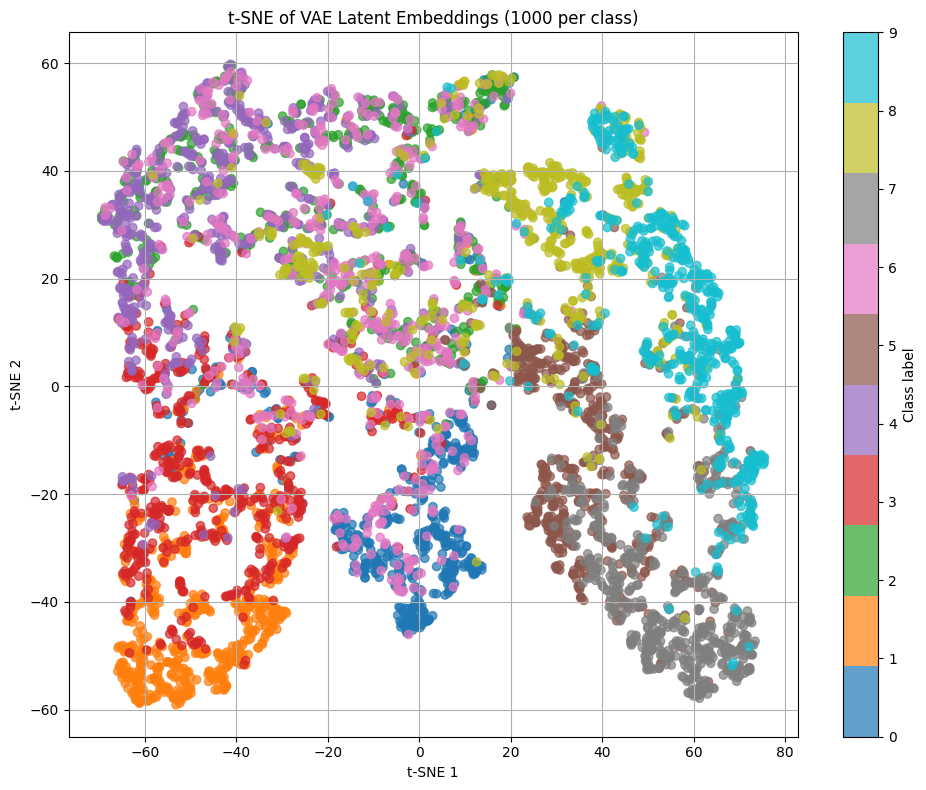

In [ ]:
# Plot


plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab10", alpha=0.7)
plt.title("t-SNE of VAE Latent Embeddings (1000 per class)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=range(10), label="Class label")
plt.grid(True)
plt.tight_layout()
plt.show()

CART

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree

In [94]:

X = df.drop(columns=["label"]).values
y = df["label"].values

In [97]:
# 2. Split into train/test sets


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize CART model (Decision Tree)
clf = DecisionTreeClassifier(max_depth=12, random_state=42)

# 4. Train
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [98]:
# 5. Evaluate
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.6458333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      1200
           1       0.83      0.78      0.81      1200
           2       0.43      0.47      0.45      1200
           3       0.59      0.67      0.63      1200
           4       0.55      0.57      0.56      1200
           5       0.71      0.71      0.71      1200
           6       0.37      0.30      0.33      1200
           7       0.76      0.76      0.76      1200
           8       0.68      0.69      0.68      1200
           9       0.79      0.79      0.79      1200

    accuracy                           0.65     12000
   macro avg       0.64      0.65      0.64     12000
weighted avg       0.64      0.65      0.64     12000



VQVAE

In [99]:
import torch, pandas as pd
from tqdm import tqdm

In [104]:
%run VQVAE.py      # trains for 5 epochs and returns to the prompt


Training:   1%|          | 1/157 [00:00<00:41,  3.72it/s]

The total number of params is 642363


Training:   1%|▏         | 2/157 [00:00<00:35,  4.34it/s]

The total number of params is 642363


Training:   2%|▏         | 3/157 [00:00<00:34,  4.49it/s]

The total number of params is 642363


Training:   3%|▎         | 4/157 [00:00<00:33,  4.60it/s]

The total number of params is 642363


Training:   3%|▎         | 5/157 [00:01<00:32,  4.66it/s]

The total number of params is 642363
The total number of params is 642363


Training:   4%|▍         | 7/157 [00:01<00:31,  4.72it/s]

The total number of params is 642363


Training:   5%|▌         | 8/157 [00:01<00:31,  4.68it/s]

The total number of params is 642363


Training:   6%|▌         | 9/157 [00:02<00:34,  4.35it/s]

The total number of params is 642363


Training:   6%|▋         | 10/157 [00:02<00:32,  4.50it/s]

The total number of params is 642363
The total number of params is 642363


Training:   8%|▊         | 12/157 [00:02<00:33,  4.27it/s]

The total number of params is 642363


Training:   8%|▊         | 13/157 [00:02<00:33,  4.34it/s]

The total number of params is 642363


Training:   9%|▉         | 14/157 [00:03<00:32,  4.38it/s]

The total number of params is 642363


Training:  10%|▉         | 15/157 [00:03<00:31,  4.49it/s]

The total number of params is 642363


Training:  10%|█         | 16/157 [00:03<00:30,  4.58it/s]

The total number of params is 642363


Training:  11%|█         | 17/157 [00:03<00:31,  4.41it/s]

The total number of params is 642363


Training:  11%|█▏        | 18/157 [00:04<00:30,  4.58it/s]

The total number of params is 642363
The total number of params is 642363


Training:  13%|█▎        | 20/157 [00:04<00:28,  4.83it/s]

The total number of params is 642363
The total number of params is 642363


Training:  14%|█▍        | 22/157 [00:04<00:28,  4.69it/s]

The total number of params is 642363
The total number of params is 642363


Training:  15%|█▌        | 24/157 [00:05<00:27,  4.85it/s]

The total number of params is 642363


Training:  16%|█▌        | 25/157 [00:05<00:26,  4.91it/s]

The total number of params is 642363
The total number of params is 642363


Training:  17%|█▋        | 27/157 [00:05<00:26,  4.87it/s]

The total number of params is 642363
The total number of params is 642363


Training:  18%|█▊        | 29/157 [00:06<00:27,  4.67it/s]

The total number of params is 642363


Training:  19%|█▉        | 30/157 [00:06<00:26,  4.74it/s]

The total number of params is 642363


Training:  20%|█▉        | 31/157 [00:06<00:27,  4.55it/s]

The total number of params is 642363
The total number of params is 642363


Training:  21%|██        | 33/157 [00:07<00:25,  4.87it/s]

The total number of params is 642363
The total number of params is 642363


Training:  22%|██▏       | 35/157 [00:07<00:24,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  24%|██▎       | 37/157 [00:07<00:23,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:  25%|██▍       | 39/157 [00:08<00:22,  5.23it/s]

The total number of params is 642363
The total number of params is 642363


Training:  26%|██▌       | 41/157 [00:08<00:22,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  27%|██▋       | 43/157 [00:09<00:22,  5.13it/s]

The total number of params is 642363
The total number of params is 642363


Training:  29%|██▊       | 45/157 [00:09<00:21,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:  30%|██▉       | 47/157 [00:09<00:23,  4.69it/s]

The total number of params is 642363


Training:  31%|███       | 48/157 [00:10<00:26,  4.19it/s]

The total number of params is 642363


Training:  31%|███       | 49/157 [00:10<00:27,  3.99it/s]

The total number of params is 642363


Training:  32%|███▏      | 50/157 [00:10<00:25,  4.16it/s]

The total number of params is 642363


Training:  32%|███▏      | 51/157 [00:10<00:24,  4.25it/s]

The total number of params is 642363


Training:  33%|███▎      | 52/157 [00:11<00:24,  4.24it/s]

The total number of params is 642363


Training:  34%|███▍      | 53/157 [00:11<00:23,  4.47it/s]

The total number of params is 642363
The total number of params is 642363


Training:  35%|███▌      | 55/157 [00:11<00:21,  4.75it/s]

The total number of params is 642363
The total number of params is 642363


Training:  36%|███▋      | 57/157 [00:12<00:20,  4.95it/s]

The total number of params is 642363
The total number of params is 642363


Training:  38%|███▊      | 59/157 [00:12<00:19,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  39%|███▉      | 61/157 [00:12<00:19,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  40%|████      | 63/157 [00:13<00:18,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  41%|████▏     | 65/157 [00:13<00:18,  4.85it/s]

The total number of params is 642363
The total number of params is 642363


Training:  43%|████▎     | 67/157 [00:14<00:17,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  44%|████▍     | 69/157 [00:14<00:17,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  45%|████▌     | 71/157 [00:14<00:16,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:  46%|████▋     | 73/157 [00:15<00:16,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  48%|████▊     | 75/157 [00:15<00:15,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:  49%|████▉     | 77/157 [00:16<00:15,  5.16it/s]

The total number of params is 642363
The total number of params is 642363


Training:  50%|█████     | 79/157 [00:16<00:15,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:  52%|█████▏    | 81/157 [00:16<00:15,  4.97it/s]

The total number of params is 642363
The total number of params is 642363


Training:  53%|█████▎    | 83/157 [00:17<00:15,  4.76it/s]

The total number of params is 642363
The total number of params is 642363


Training:  54%|█████▍    | 85/157 [00:17<00:14,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  55%|█████▌    | 87/157 [00:18<00:13,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  57%|█████▋    | 89/157 [00:18<00:13,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  58%|█████▊    | 91/157 [00:18<00:12,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  59%|█████▉    | 93/157 [00:19<00:12,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  61%|██████    | 95/157 [00:19<00:12,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:  62%|██████▏   | 97/157 [00:20<00:11,  5.17it/s]

The total number of params is 642363
The total number of params is 642363


Training:  63%|██████▎   | 99/157 [00:20<00:11,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  64%|██████▍   | 101/157 [00:20<00:10,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:  66%|██████▌   | 103/157 [00:21<00:11,  4.89it/s]

The total number of params is 642363
The total number of params is 642363


Training:  67%|██████▋   | 105/157 [00:21<00:10,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  68%|██████▊   | 107/157 [00:22<00:10,  4.78it/s]

The total number of params is 642363


Training:  69%|██████▉   | 108/157 [00:22<00:10,  4.87it/s]

The total number of params is 642363
The total number of params is 642363


Training:  70%|███████   | 110/157 [00:22<00:09,  4.99it/s]

The total number of params is 642363
The total number of params is 642363


Training:  71%|███████▏  | 112/157 [00:23<00:08,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  73%|███████▎  | 114/157 [00:23<00:08,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  74%|███████▍  | 116/157 [00:23<00:08,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  75%|███████▌  | 118/157 [00:24<00:07,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:  76%|███████▋  | 120/157 [00:24<00:07,  4.80it/s]

The total number of params is 642363
The total number of params is 642363


Training:  78%|███████▊  | 122/157 [00:25<00:07,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  79%|███████▉  | 124/157 [00:25<00:06,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  80%|████████  | 126/157 [00:25<00:06,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:  82%|████████▏ | 128/157 [00:26<00:05,  5.16it/s]

The total number of params is 642363
The total number of params is 642363


Training:  83%|████████▎ | 130/157 [00:26<00:05,  4.86it/s]

The total number of params is 642363


Training:  83%|████████▎ | 131/157 [00:26<00:06,  4.31it/s]

The total number of params is 642363


Training:  84%|████████▍ | 132/157 [00:27<00:05,  4.36it/s]

The total number of params is 642363


Training:  85%|████████▍ | 133/157 [00:27<00:05,  4.53it/s]

The total number of params is 642363


Training:  85%|████████▌ | 134/157 [00:27<00:05,  4.58it/s]

The total number of params is 642363
The total number of params is 642363


Training:  87%|████████▋ | 136/157 [00:28<00:05,  4.07it/s]

The total number of params is 642363


Training:  87%|████████▋ | 137/157 [00:28<00:04,  4.24it/s]

The total number of params is 642363


Training:  88%|████████▊ | 138/157 [00:28<00:04,  4.31it/s]

The total number of params is 642363


Training:  89%|████████▊ | 139/157 [00:28<00:04,  4.49it/s]

The total number of params is 642363
The total number of params is 642363


Training:  90%|████████▉ | 141/157 [00:29<00:03,  4.81it/s]

The total number of params is 642363
The total number of params is 642363


Training:  91%|█████████ | 143/157 [00:29<00:02,  4.86it/s]

The total number of params is 642363


Training:  92%|█████████▏| 144/157 [00:29<00:02,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  93%|█████████▎| 146/157 [00:30<00:02,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  94%|█████████▍| 148/157 [00:30<00:01,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  96%|█████████▌| 150/157 [00:31<00:01,  4.41it/s]

The total number of params is 642363


Training:  96%|█████████▌| 151/157 [00:31<00:01,  4.26it/s]

The total number of params is 642363


Training:  97%|█████████▋| 152/157 [00:31<00:01,  4.10it/s]

The total number of params is 642363


Training:  97%|█████████▋| 153/157 [00:31<00:00,  4.22it/s]

The total number of params is 642363


Training:  98%|█████████▊| 154/157 [00:32<00:00,  4.34it/s]

The total number of params is 642363


Training:  99%|█████████▊| 155/157 [00:32<00:00,  4.51it/s]

The total number of params is 642363


The total number of params is 642363
The total number of params is 642363


Testing:   0%|          | 0/313 [00:00<?, ?it/s]/Users/prateekgautam/.pyenv/versions/3.10.16/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training:   1%|          | 1/157 [00:00<00:30,  5.18it/s] 

The total number of params is 642363
The total number of params is 642363


Training:   2%|▏         | 3/157 [00:00<00:30,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:   3%|▎         | 5/157 [00:00<00:30,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:   4%|▍         | 7/157 [00:01<00:29,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:   6%|▌         | 9/157 [00:01<00:30,  4.82it/s]

The total number of params is 642363
The total number of params is 642363


Training:   7%|▋         | 11/157 [00:02<00:30,  4.86it/s]

The total number of params is 642363
The total number of params is 642363


Training:   8%|▊         | 13/157 [00:02<00:29,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  10%|▉         | 15/157 [00:03<00:28,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  11%|█         | 17/157 [00:03<00:27,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  12%|█▏        | 19/157 [00:03<00:27,  4.96it/s]

The total number of params is 642363
The total number of params is 642363


Training:  13%|█▎        | 21/157 [00:04<00:27,  4.97it/s]

The total number of params is 642363
The total number of params is 642363


Training:  15%|█▍        | 23/157 [00:04<00:27,  4.95it/s]

The total number of params is 642363
The total number of params is 642363


Training:  16%|█▌        | 25/157 [00:05<00:26,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  17%|█▋        | 27/157 [00:05<00:27,  4.74it/s]

The total number of params is 642363
The total number of params is 642363


Training:  18%|█▊        | 29/157 [00:05<00:26,  4.90it/s]

The total number of params is 642363
The total number of params is 642363


Training:  20%|█▉        | 31/157 [00:06<00:25,  4.95it/s]

The total number of params is 642363
The total number of params is 642363


Training:  21%|██        | 33/157 [00:06<00:24,  4.97it/s]

The total number of params is 642363
The total number of params is 642363


Training:  22%|██▏       | 35/157 [00:07<00:24,  4.99it/s]

The total number of params is 642363
The total number of params is 642363


Training:  24%|██▎       | 37/157 [00:07<00:24,  4.97it/s]

The total number of params is 642363
The total number of params is 642363


Training:  25%|██▍       | 39/157 [00:07<00:23,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  26%|██▌       | 41/157 [00:08<00:24,  4.67it/s]

The total number of params is 642363
The total number of params is 642363


Training:  27%|██▋       | 43/157 [00:08<00:25,  4.47it/s]

The total number of params is 642363


Training:  28%|██▊       | 44/157 [00:09<00:25,  4.45it/s]

The total number of params is 642363


Training:  29%|██▊       | 45/157 [00:09<00:25,  4.44it/s]

The total number of params is 642363


Training:  29%|██▉       | 46/157 [00:09<00:24,  4.53it/s]

The total number of params is 642363
The total number of params is 642363


Training:  31%|███       | 48/157 [00:09<00:23,  4.55it/s]

The total number of params is 642363


Training:  31%|███       | 49/157 [00:10<00:23,  4.67it/s]

The total number of params is 642363


Training:  32%|███▏      | 50/157 [00:10<00:22,  4.73it/s]

The total number of params is 642363


Training:  32%|███▏      | 51/157 [00:10<00:22,  4.76it/s]

The total number of params is 642363


Training:  33%|███▎      | 52/157 [00:10<00:22,  4.76it/s]

The total number of params is 642363


Training:  34%|███▍      | 53/157 [00:10<00:23,  4.42it/s]

The total number of params is 642363


Training:  34%|███▍      | 54/157 [00:11<00:22,  4.58it/s]

The total number of params is 642363
The total number of params is 642363


Training:  36%|███▌      | 56/157 [00:11<00:21,  4.79it/s]

The total number of params is 642363
The total number of params is 642363


Training:  37%|███▋      | 58/157 [00:11<00:20,  4.86it/s]

The total number of params is 642363
The total number of params is 642363


Training:  38%|███▊      | 60/157 [00:12<00:19,  4.88it/s]

The total number of params is 642363
The total number of params is 642363


Training:  39%|███▉      | 62/157 [00:12<00:19,  4.96it/s]

The total number of params is 642363
The total number of params is 642363


Training:  41%|████      | 64/157 [00:13<00:18,  4.96it/s]

The total number of params is 642363
The total number of params is 642363


Training:  42%|████▏     | 66/157 [00:13<00:18,  4.96it/s]

The total number of params is 642363


Training:  43%|████▎     | 67/157 [00:13<00:18,  4.87it/s]

The total number of params is 642363


Training:  43%|████▎     | 68/157 [00:14<00:18,  4.86it/s]

The total number of params is 642363


Training:  44%|████▍     | 69/157 [00:14<00:19,  4.61it/s]

The total number of params is 642363
The total number of params is 642363


Training:  45%|████▌     | 71/157 [00:14<00:17,  4.80it/s]

The total number of params is 642363
The total number of params is 642363


Training:  46%|████▋     | 73/157 [00:15<00:17,  4.86it/s]

The total number of params is 642363
The total number of params is 642363


Training:  48%|████▊     | 75/157 [00:15<00:16,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  49%|████▉     | 77/157 [00:15<00:16,  4.96it/s]

The total number of params is 642363
The total number of params is 642363


Training:  50%|█████     | 79/157 [00:16<00:15,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  52%|█████▏    | 81/157 [00:16<00:15,  4.99it/s]

The total number of params is 642363
The total number of params is 642363


Training:  53%|█████▎    | 83/157 [00:17<00:14,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  54%|█████▍    | 85/157 [00:17<00:15,  4.63it/s]

The total number of params is 642363
The total number of params is 642363


Training:  55%|█████▌    | 87/157 [00:17<00:14,  4.80it/s]

The total number of params is 642363
The total number of params is 642363


Training:  57%|█████▋    | 89/157 [00:18<00:14,  4.85it/s]

The total number of params is 642363
The total number of params is 642363


Training:  58%|█████▊    | 91/157 [00:18<00:13,  4.82it/s]

The total number of params is 642363


Training:  59%|█████▊    | 92/157 [00:18<00:13,  4.85it/s]

The total number of params is 642363


Training:  59%|█████▉    | 93/157 [00:19<00:13,  4.84it/s]

The total number of params is 642363


Training:  60%|█████▉    | 94/157 [00:19<00:13,  4.80it/s]

The total number of params is 642363


Training:  61%|██████    | 95/157 [00:19<00:12,  4.80it/s]

The total number of params is 642363


Training:  61%|██████    | 96/157 [00:19<00:12,  4.81it/s]

The total number of params is 642363


Training:  62%|██████▏   | 97/157 [00:20<00:12,  4.66it/s]

The total number of params is 642363


Training:  62%|██████▏   | 98/157 [00:20<00:13,  4.31it/s]

The total number of params is 642363


Training:  63%|██████▎   | 99/157 [00:20<00:13,  4.36it/s]

The total number of params is 642363


Training:  64%|██████▎   | 100/157 [00:20<00:13,  4.35it/s]

The total number of params is 642363


Training:  64%|██████▍   | 101/157 [00:21<00:13,  4.25it/s]

The total number of params is 642363


Training:  65%|██████▍   | 102/157 [00:21<00:12,  4.24it/s]

The total number of params is 642363


Training:  66%|██████▌   | 103/157 [00:21<00:13,  4.14it/s]

The total number of params is 642363


Training:  66%|██████▌   | 104/157 [00:21<00:13,  4.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  68%|██████▊   | 106/157 [00:22<00:13,  3.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  69%|██████▉   | 108/157 [00:22<00:11,  4.36it/s]

The total number of params is 642363
The total number of params is 642363


Training:  70%|███████   | 110/157 [00:23<00:10,  4.45it/s]

The total number of params is 642363
The total number of params is 642363


Training:  71%|███████   | 111/157 [00:23<00:10,  4.56it/s]

The total number of params is 642363


Training:  72%|███████▏  | 113/157 [00:23<00:10,  4.28it/s]

The total number of params is 642363


Training:  73%|███████▎  | 114/157 [00:24<00:09,  4.36it/s]

The total number of params is 642363


Training:  73%|███████▎  | 115/157 [00:24<00:09,  4.46it/s]

The total number of params is 642363


Training:  74%|███████▍  | 116/157 [00:24<00:08,  4.57it/s]

The total number of params is 642363


Training:  75%|███████▍  | 117/157 [00:24<00:08,  4.64it/s]

The total number of params is 642363


Training:  75%|███████▌  | 118/157 [00:24<00:08,  4.66it/s]

The total number of params is 642363


Training:  76%|███████▌  | 119/157 [00:25<00:08,  4.65it/s]

The total number of params is 642363


Training:  76%|███████▋  | 120/157 [00:25<00:08,  4.43it/s]

The total number of params is 642363


Training:  77%|███████▋  | 121/157 [00:25<00:07,  4.55it/s]

The total number of params is 642363
The total number of params is 642363


Training:  78%|███████▊  | 123/157 [00:26<00:07,  4.73it/s]

The total number of params is 642363
The total number of params is 642363


Training:  80%|███████▉  | 125/157 [00:26<00:06,  4.80it/s]

The total number of params is 642363
The total number of params is 642363


Training:  81%|████████  | 127/157 [00:26<00:06,  4.84it/s]

The total number of params is 642363


Training:  82%|████████▏ | 128/157 [00:27<00:06,  4.78it/s]

The total number of params is 642363


Training:  82%|████████▏ | 129/157 [00:27<00:05,  4.77it/s]

The total number of params is 642363


Training:  83%|████████▎ | 130/157 [00:27<00:05,  4.75it/s]

The total number of params is 642363


Training:  83%|████████▎ | 131/157 [00:27<00:05,  4.69it/s]

The total number of params is 642363


Training:  84%|████████▍ | 132/157 [00:27<00:05,  4.44it/s]

The total number of params is 642363


Training:  85%|████████▍ | 133/157 [00:28<00:05,  4.52it/s]

The total number of params is 642363


Training:  85%|████████▌ | 134/157 [00:28<00:04,  4.61it/s]

The total number of params is 642363


Training:  86%|████████▌ | 135/157 [00:28<00:04,  4.63it/s]

The total number of params is 642363


Training:  87%|████████▋ | 136/157 [00:28<00:04,  4.31it/s]

The total number of params is 642363


Training:  87%|████████▋ | 137/157 [00:29<00:04,  4.43it/s]

The total number of params is 642363


Training:  88%|████████▊ | 138/157 [00:29<00:04,  4.49it/s]

The total number of params is 642363


Training:  89%|████████▊ | 139/157 [00:29<00:04,  4.45it/s]

The total number of params is 642363


Training:  89%|████████▉ | 140/157 [00:29<00:03,  4.53it/s]

The total number of params is 642363


Training:  90%|████████▉ | 141/157 [00:29<00:03,  4.55it/s]

The total number of params is 642363


Training:  90%|█████████ | 142/157 [00:30<00:03,  4.36it/s]

The total number of params is 642363


Training:  91%|█████████ | 143/157 [00:30<00:03,  4.46it/s]

The total number of params is 642363


Training:  92%|█████████▏| 144/157 [00:30<00:02,  4.57it/s]

The total number of params is 642363


Training:  92%|█████████▏| 145/157 [00:30<00:02,  4.63it/s]

The total number of params is 642363


Training:  93%|█████████▎| 146/157 [00:31<00:02,  4.64it/s]

The total number of params is 642363


Training:  94%|█████████▎| 147/157 [00:31<00:02,  4.69it/s]

The total number of params is 642363


Training:  94%|█████████▍| 148/157 [00:31<00:01,  4.67it/s]

The total number of params is 642363


Training:  95%|█████████▍| 149/157 [00:31<00:01,  4.69it/s]

The total number of params is 642363


Training:  96%|█████████▌| 150/157 [00:31<00:01,  4.45it/s]

The total number of params is 642363


Training:  96%|█████████▌| 151/157 [00:32<00:01,  4.07it/s]

The total number of params is 642363


Training:  97%|█████████▋| 152/157 [00:32<00:01,  4.28it/s]

The total number of params is 642363
The total number of params is 642363


Training:  98%|█████████▊| 154/157 [00:32<00:00,  4.52it/s]

The total number of params is 642363


Training:  99%|█████████▊| 155/157 [00:33<00:00,  4.57it/s]

The total number of params is 642363


The total number of params is 642363
The total number of params is 642363


Training:   1%|          | 1/157 [00:00<00:29,  5.23it/s] 

The total number of params is 642363
The total number of params is 642363


Training:   2%|▏         | 3/157 [00:00<00:30,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:   3%|▎         | 5/157 [00:01<00:30,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:   4%|▍         | 7/157 [00:01<00:33,  4.54it/s]

The total number of params is 642363


Training:   5%|▌         | 8/157 [00:01<00:32,  4.65it/s]

The total number of params is 642363


Training:   6%|▌         | 9/157 [00:01<00:32,  4.60it/s]

The total number of params is 642363


Training:   6%|▋         | 10/157 [00:02<00:31,  4.68it/s]

The total number of params is 642363


Training:   7%|▋         | 11/157 [00:02<00:31,  4.70it/s]

The total number of params is 642363


Training:   8%|▊         | 12/157 [00:02<00:30,  4.74it/s]

The total number of params is 642363


Training:   8%|▊         | 13/157 [00:02<00:30,  4.75it/s]

The total number of params is 642363


Training:   9%|▉         | 14/157 [00:02<00:30,  4.74it/s]

The total number of params is 642363


Training:  10%|▉         | 15/157 [00:03<00:30,  4.70it/s]

The total number of params is 642363


Training:  10%|█         | 16/157 [00:03<00:29,  4.71it/s]

The total number of params is 642363


Training:  11%|█         | 17/157 [00:03<00:31,  4.41it/s]

The total number of params is 642363


Training:  11%|█▏        | 18/157 [00:03<00:30,  4.54it/s]

The total number of params is 642363


Training:  12%|█▏        | 19/157 [00:04<00:30,  4.58it/s]

The total number of params is 642363


Training:  13%|█▎        | 20/157 [00:04<00:30,  4.54it/s]

The total number of params is 642363


Training:  13%|█▎        | 21/157 [00:04<00:30,  4.51it/s]

The total number of params is 642363


Training:  14%|█▍        | 22/157 [00:04<00:29,  4.57it/s]

The total number of params is 642363


Training:  15%|█▍        | 23/157 [00:04<00:28,  4.62it/s]

The total number of params is 642363


Training:  15%|█▌        | 24/157 [00:05<00:29,  4.45it/s]

The total number of params is 642363


Training:  16%|█▌        | 25/157 [00:05<00:30,  4.35it/s]

The total number of params is 642363


Training:  17%|█▋        | 26/157 [00:05<00:32,  4.07it/s]

The total number of params is 642363


Training:  17%|█▋        | 27/157 [00:05<00:31,  4.07it/s]

The total number of params is 642363


Training:  18%|█▊        | 28/157 [00:06<00:31,  4.13it/s]

The total number of params is 642363


Training:  18%|█▊        | 29/157 [00:06<00:29,  4.32it/s]

The total number of params is 642363


Training:  19%|█▉        | 30/157 [00:06<00:28,  4.39it/s]

The total number of params is 642363


Training:  20%|█▉        | 31/157 [00:06<00:27,  4.50it/s]

The total number of params is 642363


Training:  20%|██        | 32/157 [00:07<00:27,  4.59it/s]

The total number of params is 642363


Training:  21%|██        | 33/157 [00:07<00:26,  4.62it/s]

The total number of params is 642363


Training:  22%|██▏       | 34/157 [00:07<00:26,  4.67it/s]

The total number of params is 642363


Training:  22%|██▏       | 35/157 [00:07<00:27,  4.37it/s]

The total number of params is 642363


Training:  23%|██▎       | 36/157 [00:07<00:26,  4.49it/s]

The total number of params is 642363


Training:  24%|██▎       | 37/157 [00:08<00:26,  4.57it/s]

The total number of params is 642363


Training:  24%|██▍       | 38/157 [00:08<00:25,  4.61it/s]

The total number of params is 642363


Training:  25%|██▍       | 39/157 [00:08<00:25,  4.65it/s]

The total number of params is 642363


Training:  25%|██▌       | 40/157 [00:08<00:25,  4.66it/s]

The total number of params is 642363


Training:  26%|██▌       | 41/157 [00:08<00:24,  4.68it/s]

The total number of params is 642363


Training:  27%|██▋       | 42/157 [00:09<00:24,  4.70it/s]

The total number of params is 642363


Training:  27%|██▋       | 43/157 [00:09<00:24,  4.70it/s]

The total number of params is 642363


Training:  28%|██▊       | 44/157 [00:09<00:25,  4.46it/s]

The total number of params is 642363


Training:  29%|██▊       | 45/157 [00:09<00:24,  4.52it/s]

The total number of params is 642363
The total number of params is 642363


Training:  30%|██▉       | 47/157 [00:10<00:23,  4.66it/s]

The total number of params is 642363
The total number of params is 642363


Training:  31%|███       | 49/157 [00:10<00:22,  4.72it/s]

The total number of params is 642363


Training:  32%|███▏      | 50/157 [00:10<00:22,  4.74it/s]

The total number of params is 642363


Training:  32%|███▏      | 51/157 [00:11<00:22,  4.78it/s]

The total number of params is 642363


Training:  33%|███▎      | 52/157 [00:11<00:21,  4.86it/s]

The total number of params is 642363
The total number of params is 642363


Training:  34%|███▍      | 54/157 [00:11<00:20,  4.96it/s]

The total number of params is 642363
The total number of params is 642363


Training:  36%|███▌      | 56/157 [00:12<00:20,  4.99it/s]

The total number of params is 642363
The total number of params is 642363


Training:  37%|███▋      | 58/157 [00:12<00:19,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  38%|███▊      | 60/157 [00:12<00:19,  4.85it/s]

The total number of params is 642363
The total number of params is 642363


Training:  39%|███▉      | 62/157 [00:13<00:19,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  41%|████      | 64/157 [00:13<00:18,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  42%|████▏     | 66/157 [00:14<00:18,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  43%|████▎     | 68/157 [00:14<00:17,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  45%|████▍     | 70/157 [00:14<00:16,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  46%|████▌     | 72/157 [00:15<00:16,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  47%|████▋     | 74/157 [00:15<00:16,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  48%|████▊     | 76/157 [00:16<00:17,  4.74it/s]

The total number of params is 642363


Training:  49%|████▉     | 77/157 [00:16<00:17,  4.49it/s]

The total number of params is 642363


Training:  50%|████▉     | 78/157 [00:16<00:18,  4.32it/s]

The total number of params is 642363
The total number of params is 642363


Training:  51%|█████     | 80/157 [00:17<00:16,  4.66it/s]

The total number of params is 642363
The total number of params is 642363


Training:  52%|█████▏    | 82/157 [00:17<00:15,  4.84it/s]

The total number of params is 642363
The total number of params is 642363


Training:  54%|█████▎    | 84/157 [00:17<00:14,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  55%|█████▍    | 86/157 [00:18<00:14,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  56%|█████▌    | 88/157 [00:18<00:13,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  57%|█████▋    | 90/157 [00:18<00:13,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  59%|█████▊    | 92/157 [00:19<00:12,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  60%|█████▉    | 94/157 [00:19<00:12,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  61%|██████    | 96/157 [00:20<00:12,  4.72it/s]

The total number of params is 642363


Training:  62%|██████▏   | 97/157 [00:20<00:12,  4.84it/s]

The total number of params is 642363
The total number of params is 642363


Training:  63%|██████▎   | 99/157 [00:20<00:11,  4.97it/s]

The total number of params is 642363
The total number of params is 642363


Training:  64%|██████▍   | 101/157 [00:21<00:11,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  66%|██████▌   | 103/157 [00:21<00:10,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  67%|██████▋   | 105/157 [00:21<00:10,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  68%|██████▊   | 107/157 [00:22<00:09,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  69%|██████▉   | 109/157 [00:22<00:09,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  71%|███████   | 111/157 [00:23<00:09,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  72%|███████▏  | 113/157 [00:23<00:08,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  73%|███████▎  | 115/157 [00:23<00:08,  4.79it/s]

The total number of params is 642363
The total number of params is 642363


Training:  75%|███████▍  | 117/157 [00:24<00:08,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  76%|███████▌  | 119/157 [00:24<00:07,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  77%|███████▋  | 121/157 [00:25<00:07,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  78%|███████▊  | 123/157 [00:25<00:07,  4.81it/s]

The total number of params is 642363
The total number of params is 642363


Training:  80%|███████▉  | 125/157 [00:26<00:06,  4.94it/s]

The total number of params is 642363
The total number of params is 642363


Training:  81%|████████  | 127/157 [00:26<00:05,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  82%|████████▏ | 129/157 [00:26<00:05,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  83%|████████▎ | 131/157 [00:27<00:05,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  85%|████████▍ | 133/157 [00:27<00:05,  4.78it/s]

The total number of params is 642363


Training:  85%|████████▌ | 134/157 [00:27<00:04,  4.87it/s]

The total number of params is 642363
The total number of params is 642363


Training:  87%|████████▋ | 136/157 [00:28<00:04,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  88%|████████▊ | 138/157 [00:28<00:03,  4.79it/s]

The total number of params is 642363
The total number of params is 642363


Training:  89%|████████▉ | 140/157 [00:29<00:03,  4.94it/s]

The total number of params is 642363
The total number of params is 642363


Training:  90%|█████████ | 142/157 [00:29<00:02,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  92%|█████████▏| 144/157 [00:29<00:02,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  93%|█████████▎| 146/157 [00:30<00:02,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  94%|█████████▍| 148/157 [00:30<00:01,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  96%|█████████▌| 150/157 [00:31<00:01,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  97%|█████████▋| 152/157 [00:31<00:01,  4.90it/s]

The total number of params is 642363
The total number of params is 642363


Training:  98%|█████████▊| 154/157 [00:31<00:00,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


The total number of params is 642363
The total number of params is 642363


Training:   1%|          | 1/157 [00:00<00:29,  5.22it/s] 

The total number of params is 642363
The total number of params is 642363


Training:   2%|▏         | 3/157 [00:00<00:29,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:   3%|▎         | 5/157 [00:00<00:29,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:   4%|▍         | 7/157 [00:01<00:29,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:   6%|▌         | 9/157 [00:01<00:28,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:   7%|▋         | 11/157 [00:02<00:28,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:   8%|▊         | 13/157 [00:02<00:29,  4.90it/s]

The total number of params is 642363
The total number of params is 642363


Training:  10%|▉         | 15/157 [00:02<00:28,  4.92it/s]

The total number of params is 642363


Training:  10%|█         | 16/157 [00:03<00:28,  4.99it/s]

The total number of params is 642363


Training:  11%|█         | 17/157 [00:03<00:28,  4.84it/s]

The total number of params is 642363


Training:  11%|█▏        | 18/157 [00:03<00:28,  4.89it/s]

The total number of params is 642363
The total number of params is 642363


Training:  13%|█▎        | 20/157 [00:03<00:27,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  14%|█▍        | 22/157 [00:04<00:26,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  15%|█▌        | 24/157 [00:04<00:25,  5.13it/s]

The total number of params is 642363
The total number of params is 642363


Training:  17%|█▋        | 26/157 [00:05<00:25,  5.14it/s]

The total number of params is 642363
The total number of params is 642363


Training:  18%|█▊        | 28/157 [00:05<00:25,  5.16it/s]

The total number of params is 642363
The total number of params is 642363


Training:  19%|█▉        | 30/157 [00:05<00:24,  5.15it/s]

The total number of params is 642363
The total number of params is 642363


Training:  20%|██        | 32/157 [00:06<00:25,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  22%|██▏       | 34/157 [00:06<00:24,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  23%|██▎       | 36/157 [00:07<00:24,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  24%|██▍       | 38/157 [00:07<00:23,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  25%|██▌       | 40/157 [00:07<00:22,  5.13it/s]

The total number of params is 642363
The total number of params is 642363


Training:  27%|██▋       | 42/157 [00:08<00:22,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  28%|██▊       | 44/157 [00:08<00:22,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  29%|██▉       | 46/157 [00:09<00:22,  4.90it/s]

The total number of params is 642363


Training:  30%|██▉       | 47/157 [00:09<00:23,  4.75it/s]

The total number of params is 642363


Training:  31%|███       | 48/157 [00:09<00:23,  4.71it/s]

The total number of params is 642363


Training:  31%|███       | 49/157 [00:09<00:22,  4.83it/s]

The total number of params is 642363
The total number of params is 642363


Training:  32%|███▏      | 51/157 [00:10<00:22,  4.63it/s]

The total number of params is 642363
The total number of params is 642363


Training:  34%|███▍      | 53/157 [00:10<00:21,  4.85it/s]

The total number of params is 642363
The total number of params is 642363


Training:  35%|███▌      | 55/157 [00:11<00:20,  4.89it/s]

The total number of params is 642363
The total number of params is 642363


Training:  36%|███▋      | 57/157 [00:11<00:19,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  38%|███▊      | 59/157 [00:11<00:19,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  39%|███▉      | 61/157 [00:12<00:19,  5.02it/s]

The total number of params is 642363


Training:  39%|███▉      | 62/157 [00:12<00:18,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  41%|████      | 64/157 [00:12<00:18,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  42%|████▏     | 66/157 [00:13<00:17,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  43%|████▎     | 68/157 [00:13<00:17,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  45%|████▍     | 70/157 [00:13<00:17,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  46%|████▌     | 72/157 [00:14<00:17,  4.82it/s]

The total number of params is 642363
The total number of params is 642363


Training:  47%|████▋     | 74/157 [00:14<00:16,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  48%|████▊     | 76/157 [00:15<00:16,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  50%|████▉     | 78/157 [00:15<00:15,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  51%|█████     | 80/157 [00:15<00:15,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  52%|█████▏    | 82/157 [00:16<00:14,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  54%|█████▎    | 84/157 [00:16<00:14,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  55%|█████▍    | 86/157 [00:17<00:14,  5.04it/s]

The total number of params is 642363


Training:  55%|█████▌    | 87/157 [00:17<00:13,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  57%|█████▋    | 89/157 [00:17<00:13,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  58%|█████▊    | 91/157 [00:18<00:12,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  59%|█████▉    | 93/157 [00:18<00:12,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  61%|██████    | 95/157 [00:18<00:12,  4.87it/s]

The total number of params is 642363
The total number of params is 642363


Training:  62%|██████▏   | 97/157 [00:19<00:12,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  63%|██████▎   | 99/157 [00:19<00:11,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  64%|██████▍   | 101/157 [00:20<00:10,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  66%|██████▌   | 103/157 [00:20<00:10,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  67%|██████▋   | 105/157 [00:20<00:10,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:  68%|██████▊   | 107/157 [00:21<00:09,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  69%|██████▉   | 109/157 [00:21<00:09,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  70%|███████   | 110/157 [00:21<00:09,  5.00it/s]

The total number of params is 642363


Training:  71%|███████▏  | 112/157 [00:22<00:10,  4.31it/s]

The total number of params is 642363


Training:  72%|███████▏  | 113/157 [00:22<00:10,  4.37it/s]

The total number of params is 642363


Training:  73%|███████▎  | 114/157 [00:22<00:09,  4.49it/s]

The total number of params is 642363


Training:  73%|███████▎  | 115/157 [00:23<00:09,  4.63it/s]

The total number of params is 642363
The total number of params is 642363


Training:  75%|███████▍  | 117/157 [00:23<00:08,  4.78it/s]

The total number of params is 642363
The total number of params is 642363


Training:  76%|███████▌  | 119/157 [00:23<00:07,  4.91it/s]

The total number of params is 642363
The total number of params is 642363


Training:  77%|███████▋  | 121/157 [00:24<00:07,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  78%|███████▊  | 123/157 [00:24<00:06,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  80%|███████▉  | 125/157 [00:25<00:06,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  81%|████████  | 127/157 [00:25<00:05,  5.11it/s]

The total number of params is 642363
The total number of params is 642363


Training:  82%|████████▏ | 129/157 [00:25<00:05,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  83%|████████▎ | 131/157 [00:26<00:05,  4.53it/s]

The total number of params is 642363
The total number of params is 642363


Training:  85%|████████▍ | 133/157 [00:26<00:05,  4.74it/s]

The total number of params is 642363
The total number of params is 642363


Training:  86%|████████▌ | 135/157 [00:27<00:04,  4.70it/s]

The total number of params is 642363
The total number of params is 642363


Training:  87%|████████▋ | 137/157 [00:27<00:04,  4.49it/s]

The total number of params is 642363
The total number of params is 642363


Training:  89%|████████▊ | 139/157 [00:28<00:03,  4.79it/s]

The total number of params is 642363
The total number of params is 642363


Training:  90%|████████▉ | 141/157 [00:28<00:03,  4.95it/s]

The total number of params is 642363
The total number of params is 642363


Training:  91%|█████████ | 143/157 [00:28<00:02,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  92%|█████████▏| 145/157 [00:29<00:02,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  94%|█████████▎| 147/157 [00:29<00:02,  4.83it/s]

The total number of params is 642363
The total number of params is 642363


Training:  95%|█████████▍| 149/157 [00:30<00:01,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  96%|█████████▌| 151/157 [00:30<00:01,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  97%|█████████▋| 153/157 [00:30<00:00,  4.89it/s]

The total number of params is 642363


Training:  98%|█████████▊| 154/157 [00:31<00:00,  4.67it/s]

The total number of params is 642363


Training:  99%|█████████▊| 155/157 [00:31<00:00,  4.53it/s]

The total number of params is 642363


The total number of params is 642363
The total number of params is 642363


Training:   1%|          | 1/157 [00:00<00:29,  5.22it/s] 

The total number of params is 642363
The total number of params is 642363


Training:   2%|▏         | 3/157 [00:00<00:30,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:   3%|▎         | 5/157 [00:00<00:30,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:   4%|▍         | 7/157 [00:01<00:29,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:   6%|▌         | 9/157 [00:01<00:28,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:   7%|▋         | 11/157 [00:02<00:28,  5.12it/s]

The total number of params is 642363
The total number of params is 642363


Training:   8%|▊         | 13/157 [00:02<00:28,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  10%|▉         | 15/157 [00:02<00:29,  4.77it/s]

The total number of params is 642363
The total number of params is 642363


Training:  11%|█         | 17/157 [00:03<00:28,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  12%|█▏        | 19/157 [00:03<00:27,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  13%|█▎        | 21/157 [00:04<00:27,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  15%|█▍        | 23/157 [00:04<00:26,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  16%|█▌        | 25/157 [00:04<00:26,  4.97it/s]

The total number of params is 642363


Training:  17%|█▋        | 26/157 [00:05<00:26,  5.00it/s]

The total number of params is 642363
The total number of params is 642363


Training:  18%|█▊        | 28/157 [00:05<00:25,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  19%|█▉        | 30/157 [00:05<00:25,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  20%|██        | 32/157 [00:06<00:24,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  22%|██▏       | 34/157 [00:06<00:24,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  23%|██▎       | 36/157 [00:07<00:23,  5.06it/s]

The total number of params is 642363


Training:  24%|██▎       | 37/157 [00:07<00:25,  4.63it/s]

The total number of params is 642363


Training:  24%|██▍       | 38/157 [00:07<00:25,  4.74it/s]

The total number of params is 642363
The total number of params is 642363


Training:  25%|██▌       | 40/157 [00:07<00:23,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  27%|██▋       | 42/157 [00:08<00:22,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  28%|██▊       | 44/157 [00:08<00:22,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  29%|██▉       | 46/157 [00:09<00:21,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  31%|███       | 48/157 [00:09<00:21,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  32%|███▏      | 50/157 [00:09<00:21,  5.04it/s]

The total number of params is 642363


Training:  32%|███▏      | 51/157 [00:10<00:20,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  34%|███▍      | 53/157 [00:10<00:21,  4.76it/s]

The total number of params is 642363


Training:  34%|███▍      | 54/157 [00:10<00:21,  4.75it/s]

The total number of params is 642363


Training:  35%|███▌      | 55/157 [00:11<00:21,  4.83it/s]

The total number of params is 642363
The total number of params is 642363


Training:  36%|███▋      | 57/157 [00:11<00:20,  4.95it/s]

The total number of params is 642363
The total number of params is 642363


Training:  38%|███▊      | 59/157 [00:11<00:19,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  39%|███▉      | 61/157 [00:12<00:19,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  40%|████      | 63/157 [00:12<00:18,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  41%|████▏     | 65/157 [00:12<00:18,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  43%|████▎     | 67/157 [00:13<00:17,  5.09it/s]

The total number of params is 642363
The total number of params is 642363


Training:  44%|████▍     | 69/157 [00:13<00:17,  5.10it/s]

The total number of params is 642363
The total number of params is 642363


Training:  45%|████▌     | 71/157 [00:14<00:16,  5.08it/s]

The total number of params is 642363


Training:  46%|████▌     | 72/157 [00:14<00:17,  4.75it/s]

The total number of params is 642363


Training:  46%|████▋     | 73/157 [00:14<00:17,  4.83it/s]

The total number of params is 642363
The total number of params is 642363


Training:  48%|████▊     | 75/157 [00:15<00:16,  4.83it/s]

The total number of params is 642363
The total number of params is 642363


Training:  49%|████▉     | 77/157 [00:15<00:16,  4.94it/s]

The total number of params is 642363
The total number of params is 642363


Training:  50%|█████     | 79/157 [00:15<00:15,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  52%|█████▏    | 81/157 [00:16<00:15,  4.95it/s]

The total number of params is 642363


Training:  52%|█████▏    | 82/157 [00:16<00:15,  4.76it/s]

The total number of params is 642363


Training:  53%|█████▎    | 83/157 [00:16<00:16,  4.62it/s]

The total number of params is 642363


Training:  54%|█████▎    | 84/157 [00:16<00:16,  4.56it/s]

The total number of params is 642363


Training:  54%|█████▍    | 85/157 [00:17<00:16,  4.44it/s]

The total number of params is 642363


Training:  55%|█████▍    | 86/157 [00:17<00:16,  4.30it/s]

The total number of params is 642363


Training:  55%|█████▌    | 87/157 [00:17<00:15,  4.49it/s]

The total number of params is 642363
The total number of params is 642363


Training:  57%|█████▋    | 89/157 [00:17<00:14,  4.77it/s]

The total number of params is 642363
The total number of params is 642363


Training:  58%|█████▊    | 91/157 [00:18<00:13,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  59%|█████▉    | 93/157 [00:18<00:13,  4.60it/s]

The total number of params is 642363


Training:  60%|█████▉    | 94/157 [00:19<00:13,  4.71it/s]

The total number of params is 642363


Training:  61%|██████    | 95/157 [00:19<00:12,  4.78it/s]

The total number of params is 642363


Training:  61%|██████    | 96/157 [00:19<00:12,  4.85it/s]

The total number of params is 642363
The total number of params is 642363


Training:  62%|██████▏   | 98/157 [00:19<00:11,  4.92it/s]

The total number of params is 642363


Training:  63%|██████▎   | 99/157 [00:20<00:11,  4.86it/s]

The total number of params is 642363


Training:  64%|██████▎   | 100/157 [00:20<00:12,  4.60it/s]

The total number of params is 642363


Training:  64%|██████▍   | 101/157 [00:20<00:11,  4.69it/s]

The total number of params is 642363
The total number of params is 642363


Training:  66%|██████▌   | 103/157 [00:20<00:11,  4.85it/s]

The total number of params is 642363
The total number of params is 642363


Training:  67%|██████▋   | 105/157 [00:21<00:10,  4.86it/s]

The total number of params is 642363


Training:  68%|██████▊   | 106/157 [00:21<00:10,  4.92it/s]

The total number of params is 642363
The total number of params is 642363


Training:  69%|██████▉   | 108/157 [00:21<00:09,  4.99it/s]

The total number of params is 642363
The total number of params is 642363


Training:  70%|███████   | 110/157 [00:22<00:09,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  71%|███████▏  | 112/157 [00:22<00:08,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  73%|███████▎  | 114/157 [00:23<00:08,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  74%|███████▍  | 116/157 [00:23<00:08,  5.07it/s]

The total number of params is 642363
The total number of params is 642363


Training:  75%|███████▌  | 118/157 [00:23<00:08,  4.84it/s]

The total number of params is 642363
The total number of params is 642363


Training:  76%|███████▋  | 120/157 [00:24<00:07,  4.96it/s]

The total number of params is 642363
The total number of params is 642363


Training:  78%|███████▊  | 122/157 [00:24<00:06,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  79%|███████▉  | 124/157 [00:25<00:06,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  80%|████████  | 126/157 [00:25<00:06,  4.98it/s]

The total number of params is 642363
The total number of params is 642363


Training:  82%|████████▏ | 128/157 [00:25<00:05,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  83%|████████▎ | 130/157 [00:26<00:05,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  84%|████████▍ | 132/157 [00:26<00:04,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  85%|████████▌ | 134/157 [00:27<00:04,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  87%|████████▋ | 136/157 [00:27<00:04,  4.74it/s]

The total number of params is 642363


Training:  87%|████████▋ | 137/157 [00:27<00:04,  4.81it/s]

The total number of params is 642363
The total number of params is 642363


Training:  89%|████████▊ | 139/157 [00:28<00:03,  4.93it/s]

The total number of params is 642363
The total number of params is 642363


Training:  90%|████████▉ | 141/157 [00:28<00:03,  5.01it/s]

The total number of params is 642363
The total number of params is 642363


Training:  91%|█████████ | 143/157 [00:28<00:02,  5.04it/s]

The total number of params is 642363
The total number of params is 642363


Training:  92%|█████████▏| 145/157 [00:29<00:02,  5.03it/s]

The total number of params is 642363
The total number of params is 642363


Training:  94%|█████████▎| 147/157 [00:29<00:01,  5.08it/s]

The total number of params is 642363
The total number of params is 642363


Training:  95%|█████████▍| 149/157 [00:30<00:01,  5.02it/s]

The total number of params is 642363
The total number of params is 642363


Training:  96%|█████████▌| 151/157 [00:30<00:01,  5.06it/s]

The total number of params is 642363
The total number of params is 642363


Training:  97%|█████████▋| 153/157 [00:30<00:00,  5.05it/s]

The total number of params is 642363
The total number of params is 642363


Training:  99%|█████████▊| 155/157 [00:31<00:00,  4.74it/s]

The total number of params is 642363
The total number of params is 642363


The total number of params is 642363


ran code!


In [105]:
torch.save(vae_net.state_dict(), "vqvae.pth") 

In [106]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_net = vae_net.to(device)          # assumes your trained VQVAE object is called vae_net
vae_net.eval()

VQVAE(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block1): DownBlock(
      (bn1): GroupNorm(8, 16, eps=1e-05, affine=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): GroupNorm(8, 32, eps=1e-05, affine=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_block2): DownBlock(
      (bn1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (res_block_1): ResBlock(
      (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv1): Conv2d(64, 64, ker

In [107]:
cont_chunks, disc_chunks, label_chunks = [], [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Embedding"):   # or any DataLoader you like
        x = x.to(device)

        vq_loss, quantized, enc_idx = vae_net.encode(x)

        # ---------- continuous (quantized) ----------
        z_flat   = quantized.view(quantized.size(0), -1)   # (B, latent_channels*7*7)
        cont_chunks.append(z_flat.cpu())

        # ---------- discrete (code-book indices) ----------
        idx_flat = enc_idx.view(enc_idx.size(0), -1)       # (B, 7*7)
        disc_chunks.append(idx_flat.cpu())

        label_chunks.append(y)

Embedding: 100%|██████████| 313/313 [00:10<00:00, 30.31it/s]


In [108]:
cont_arr  = torch.cat(cont_chunks).numpy()
disc_arr  = torch.cat(disc_chunks).numpy()
labels    = torch.cat(label_chunks).numpy()

In [109]:
# ---- DataFrame A: continuous vectors ----
df_cont = pd.DataFrame(
    cont_arr,
    columns=[f"z{i}" for i in range(cont_arr.shape[1])]
)
df_cont["label"] = labels


In [110]:
# ---- DataFrame B: discrete code indices ----
df_disc = pd.DataFrame(
    disc_arr,
    columns=[f"c{i}" for i in range(disc_arr.shape[1])]
)
df_disc["label"] = labels

In [112]:
sampled_df = df_cont.groupby("label").sample(n=600, random_state=42)
X = sampled_df.drop(columns=["label"]).values
y = sampled_df["label"].values

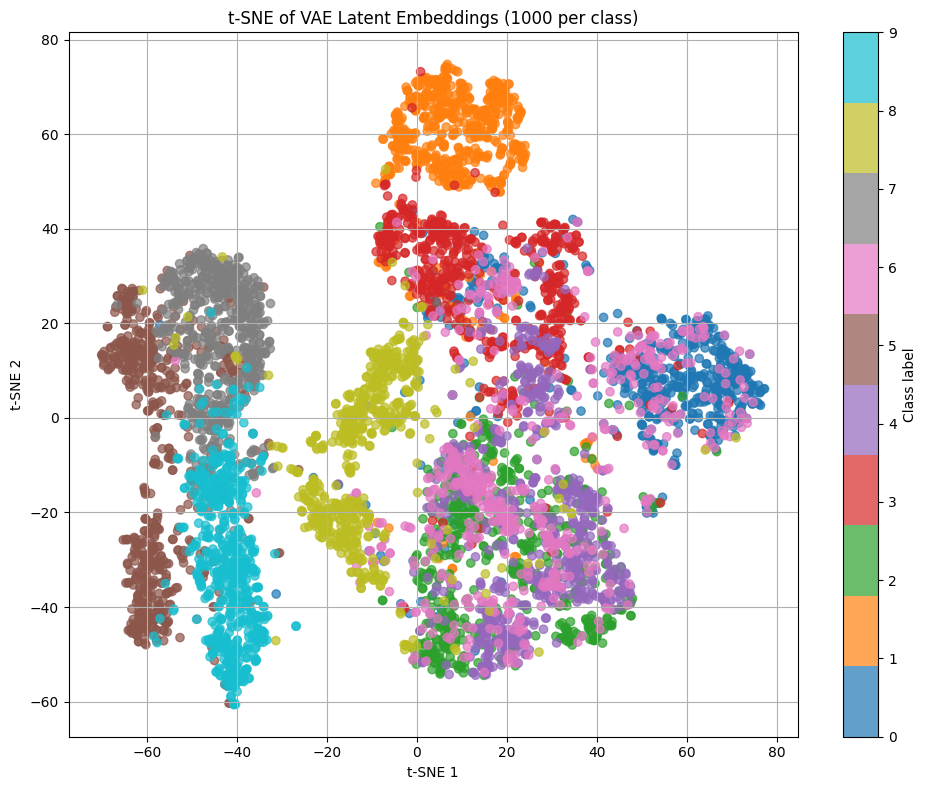

In [113]:
# Plot
# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab10", alpha=0.7)
plt.title("t-SNE of VAE Latent Embeddings (1000 per class)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=range(10), label="Class label")
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
sampled_df1 = df_disc.groupby("label").sample(n=600, random_state=42)
X = sampled_df1.drop(columns=["label"]).values
y = sampled_df1["label"].values

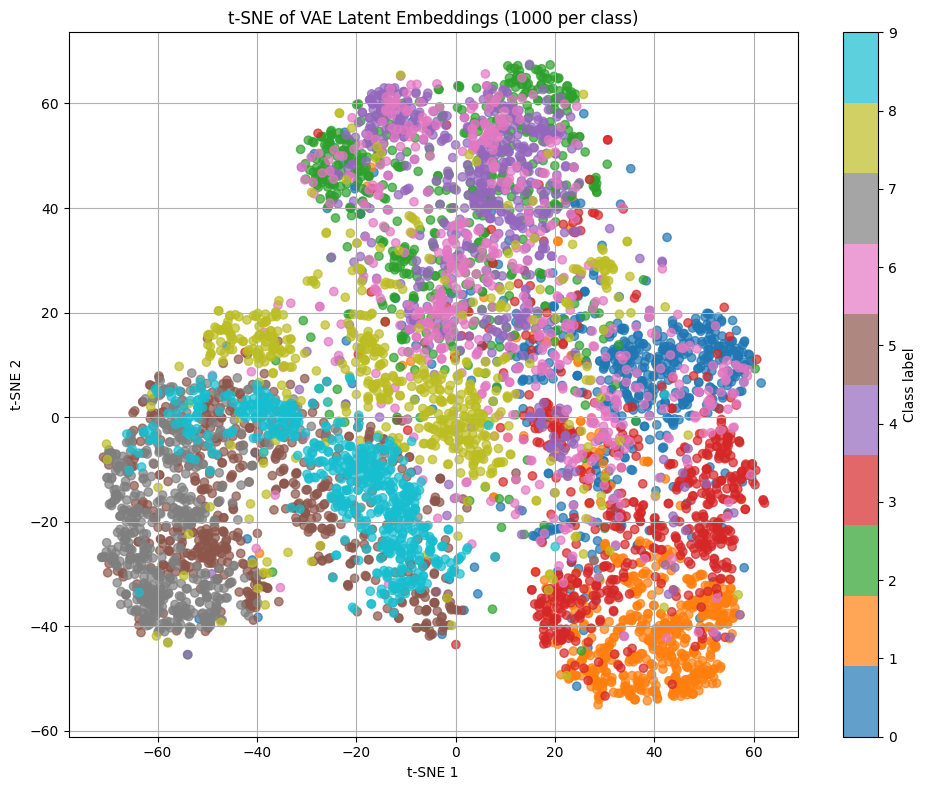

In [115]:
X_scaled = StandardScaler().fit_transform(X)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab10", alpha=0.7)
plt.title("t-SNE of VAE Latent Embeddings (1000 per class)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=range(10), label="Class label")
plt.grid(True)
plt.tight_layout()
plt.show()

In [124]:
# 2. Split into train/test sets

X = df_cont.drop(columns=["label"]).values
y = df_cont["label"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize CART model (Decision Tree)
clf = DecisionTreeClassifier(max_depth=12, random_state=42)

# 4. Train
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [125]:
# 5. Evaluate
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7215

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69       200
           1       0.88      0.88      0.88       200
           2       0.53      0.66      0.58       200
           3       0.69      0.72      0.70       200
           4       0.59      0.59      0.59       200
           5       0.83      0.77      0.80       200
           6       0.51      0.40      0.45       200
           7       0.76      0.87      0.81       200
           8       0.89      0.83      0.86       200
           9       0.87      0.81      0.84       200

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



In [118]:
# 2. Split into train/test sets

X = df_disc.drop(columns=["label"]).values
y = df_disc["label"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize CART model (Decision Tree)
clf = DecisionTreeClassifier(max_depth=12, random_state=42)

# 4. Train
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [119]:
# 5. Evaluate
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.6895

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.68       200
           1       0.85      0.88      0.86       200
           2       0.54      0.60      0.57       200
           3       0.66      0.70      0.68       200
           4       0.60      0.55      0.57       200
           5       0.75      0.72      0.74       200
           6       0.43      0.41      0.42       200
           7       0.78      0.78      0.78       200
           8       0.79      0.73      0.76       200
           9       0.81      0.84      0.83       200

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

